In [1]:
import random
import os
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras 
import gzip
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

os.chdir('../../functions/')
from models import get_class_weight, preprocessor, plot_confusion_matrix, compile_image_model, \
                    CNN_model,label_dict, revlabel_dict, recreate_labels, map_path_to_augmented


from preprocessing import create_data_set, randomize


## Models with two sizes of 7x7 kernels, 16 kernels in the first layer
### CNN network example below for 10 3x3 kernels and 14 7x7 kernels

In [2]:
DATA_DIR = "../../archive-2/"
large_labels = ["hole", "thread_error", "objects", "oil_spot"]

#walk all the files and add them to this
all_files = [filename for filename in glob.glob(DATA_DIR + "//*//*")]
all_files = [filename for filename in all_files if 'good' not in filename and 'tilda' not in filename 
             and filename.split("/")[3] in large_labels]

#shuffle
random.shuffle(all_files)

#get class names
all_labels = [filename.split("/")[-2] for filename in all_files]
all_labels_numerical = [revlabel_dict[filename.split("/")[-2]] for filename in all_files]


In [3]:
features_train_defect_array, features_eval_defect_array, \
features_test_defect_array, labels_defect_train, \
labels_defect_eval, labels_defect_test = create_data_set(all_files, all_labels_numerical, 
                                                         label_dict, revlabel_dict, 
                                                         target_samples_per_class_train = 10240, 
                                                         target_samples_per_class_eval = 1024, 
                                                         label_code=1, random_state=102)

1944 243 243
1944 243 243
unique_labels {'thread_error', 'hole', 'objects', 'oil_spot'}
unique_labels {'thread_error', 'hole', 'objects', 'oil_spot'}
40868 4094 243
len(features_train_array): 40868
features_train_array.shape: (40868, 64, 64, 3)
features_test_array.shape: (243, 64, 64, 3)
features_train_array.shape: (40868, 64, 64, 1)
features_test_array.shape: (243, 64, 64, 1)


In [4]:
class_weights = get_class_weight(list(labels_defect_train))
class_weights

9.950248756218905e-05
9.782821365681862e-05
9.823182711198428e-05
9.600614439324117e-05


{0: 9.950248756218905e-05,
 1: 9.782821365681862e-05,
 2: 9.823182711198428e-05,
 3: 9.600614439324117e-05}

In [5]:
labels_defect_train = np.array(labels_defect_train)
labels_defect_eval = np.array(labels_defect_eval)
labels_defect_test = np.array(labels_defect_test)

### Train model

NEW MODEL
filter dim = [7], number filter = 16
self.kernel_dims = [7]
self.dropout = 0.1


Model: "image_learner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input_for                 │ (None, 64, 64, 1)      │             0 │
│ _7x7_kernel_subnetwork          │                        │               │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter1_7 (Conv2D)            │ (None, 64, 64, 16)     │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization1_7           │ (None, 64, 64, 16)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1_7 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1_7 (MaxPooling2D)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter2_7 (Conv2D)            │ (None, 32, 32, 32)     │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization2_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2_7 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2_7 (MaxPooling2D)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter3_7 (Conv2D)            │ (None, 16, 16, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization3_7           │ (None, 16, 16, 64)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3_7 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3_7 (MaxPooling2D)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened5_7 (Flatten)          │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_all_subnetworks     │ (None, 4096)           │             0 │
│ (Concatenate)                   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_last (Dense)              │ (None, 100)            │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_output (Dense)          │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,888 (2.05 MB)

 Trainable params: 536,664 (2.05 MB)

 Non-trainable params: 224 (896.00 B)

None
Epoch 1/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 513ms/step - accuracy: 0.2996 - loss: 1.4007e-04 - val_accuracy: 0.2648 - val_loss: 1.4374
Epoch 2/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 514ms/step - accuracy: 0.3867 - loss: 1.2591e-04 - val_accuracy: 0.2868 - val_loss: 1.8065
Epoch 3/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 84s 525ms/step - accuracy: 0.4569 - loss: 1.1535e-04 - val_accuracy: 0.2780 - val_loss: 2.4200
Epoch 4/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 85s 532ms/step - accuracy: 0.5210 - loss: 1.0489e-04 - val_accuracy: 0.3227 - val_loss: 2.3137
Epoch 5/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 509ms/step - accuracy: 0.6128 - loss: 8.9160e-05 - val_accuracy: 0.2826 - val_loss: 2.8590
Epoch 6/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 510ms/step - accuracy: 0.7395 - loss: 6.4770e-05 - val_accuracy: 0.2946 - val_loss: 2.7979
Epoch 7/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 509ms/step - accuracy: 0.8444 - loss: 4.1818e-05 - val_accuracy: 0.3596 - val_loss: 2.8665
Epoch 8/100000
160/160

Model: "image_learner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input_for                 │ (None, 64, 64, 1)      │             0 │
│ _7x7_kernel_subnetwork          │                        │               │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter1_7 (Conv2D)            │ (None, 64, 64, 16)     │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization1_7           │ (None, 64, 64, 16)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1_7 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1_7 (MaxPooling2D)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter2_7 (Conv2D)            │ (None, 32, 32, 32)     │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization2_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2_7 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2_7 (MaxPooling2D)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter3_7 (Conv2D)            │ (None, 16, 16, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization3_7           │ (None, 16, 16, 64)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3_7 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3_7 (MaxPooling2D)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened5_7 (Flatten)          │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_all_subnetworks     │ (None, 4096)           │             0 │
│ (Concatenate)                   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_last (Dense)              │ (None, 100)            │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_output (Dense)          │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,218 (6.14 MB)

 Trainable params: 536,664 (2.05 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 1,073,330 (4.09 MB)

None
Finished fitting.  Predicting X...
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Finished predicting X with eval data set.

[[390 240  90 300]
 [ 12 780 156  48]
 [  0  96 816 112]
 [ 34 255 187 578]]
sum of diagonal = 2564


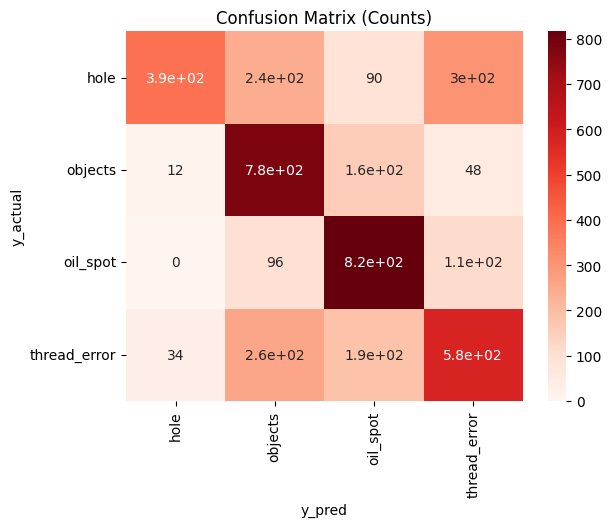


[[0.09526136 0.05862237 0.02198339 0.07327797]
 [0.00293112 0.19052272 0.03810454 0.01172447]
 [0.         0.02344895 0.19931607 0.02735711]
 [0.00830484 0.06228627 0.0456766  0.14118222]]
sum of diagonal = 0.6262823644357596


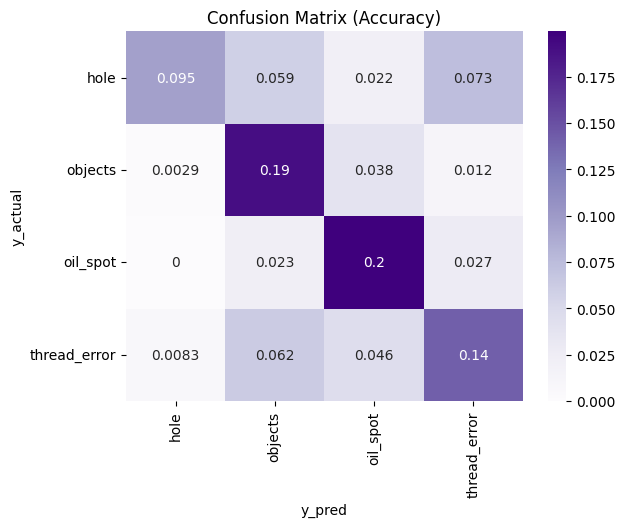


[[0.89449541 0.1750547  0.07205765 0.28901734]
 [0.02752294 0.56892779 0.12489992 0.04624277]
 [0.         0.07002188 0.65332266 0.10789981]
 [0.07798165 0.18599562 0.14971978 0.55684008]]
sum of diagonal = 2.673585937976183


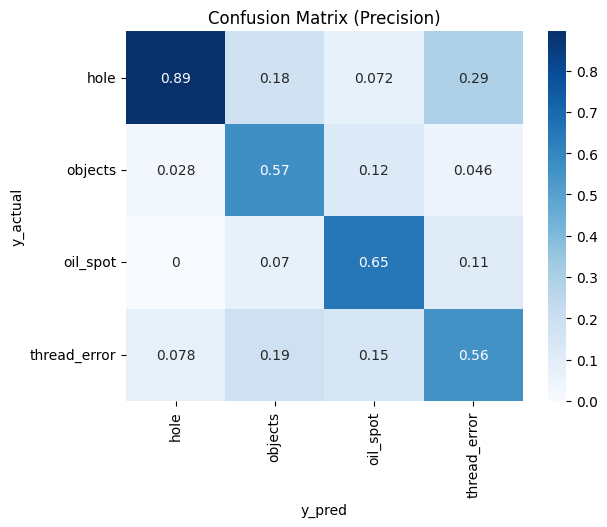


[[0.38235294 0.23529412 0.08823529 0.29411765]
 [0.01204819 0.78313253 0.15662651 0.04819277]
 [0.         0.09375    0.796875   0.109375  ]
 [0.03225806 0.24193548 0.17741935 0.5483871 ]]
sum of diagonal = 2.510747568071146


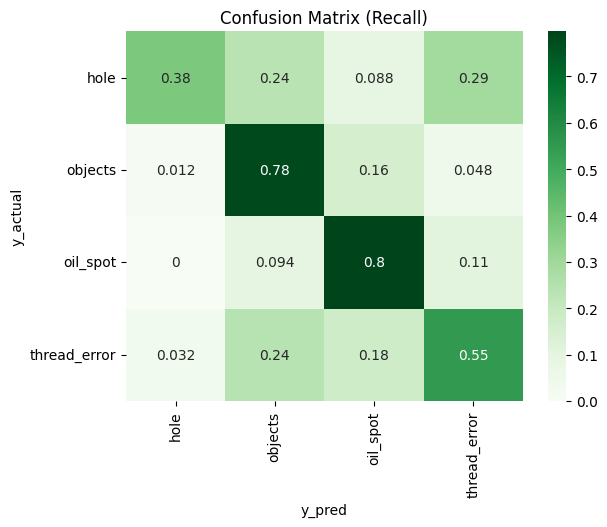

In [6]:
dim = [7]
nums_filters = 16
print('NEW MODEL')
print(f'filter dim = {dim}, number filter = {nums_filters}')
image_model = CNN_model(kernel_dims = dim, dropout=0.1,  nums_filters = nums_filters, patience = 100, lr = 0.0001, num_classes = 4)
history, image_learner = image_model.fit( features_train_defect_array, labels_defect_train, 
                                         features_eval_defect_array, labels_defect_eval, label_dict, batch_size = 256,
                                         verbose = 'auto', class_weight=class_weights)


with gzip.open(f"../data/models//defect_identification/DefID_image_learner_{str(dim)}_{str(nums_filters)}_d3blk.pckl", 'wb') as f:
    pickle.dump(image_learner, f)
with gzip.open(f"../data/models/defect_identification/DefID_history_{str(dim)}_{str(nums_filters)}_d3blk.pkl", 'wb') as f:
    pickle.dump(history, f)

NEW MODEL
filter dim = [3], number filter = 8
self.kernel_dims = [3]
self.dropout = 0.1


Model: "image_learner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input_for                 │ (None, 64, 64, 1)      │             0 │
│ _3x3_kernel_subnetwork          │                        │               │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter1_3 (Conv2D)            │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization1_3           │ (None, 64, 64, 8)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1_3 (Dropout)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1_3 (MaxPooling2D)       │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter2_3 (Conv2D)            │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization2_3           │ (None, 32, 32, 16)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2_3 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2_3 (MaxPooling2D)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter3_3 (Conv2D)            │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization3_3           │ (None, 16, 16, 32)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3_3 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3_3 (MaxPooling2D)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened5_3 (Flatten)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_all_subnetworks     │ (None, 2048)           │             0 │
│ (Concatenate)                   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_last (Dense)              │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_output (Dense)          │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,640 (826.72 KB)

 Trainable params: 211,416 (825.84 KB)

 Non-trainable params: 224 (896.00 B)

None
Epoch 1/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.2860 - loss: 1.4326e-04 - val_accuracy: 0.2731 - val_loss: 1.4700
Epoch 2/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.3470 - loss: 1.3060e-04 - val_accuracy: 0.2658 - val_loss: 1.7242
Epoch 3/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.3782 - loss: 1.2640e-04 - val_accuracy: 0.2863 - val_loss: 1.8876
Epoch 4/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.4089 - loss: 1.2249e-04 - val_accuracy: 0.2829 - val_loss: 1.9618
Epoch 5/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.4419 - loss: 1.1772e-04 - val_accuracy: 0.3024 - val_loss: 1.8838
Epoch 6/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.4657 - loss: 1.1344e-04 - val_accuracy: 0.2963 - val_loss: 1.9147
Epoch 7/100000
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.4954 - loss: 1.0876e-04 - val_accuracy: 0.2956 - val_loss: 1.8639
Epoch 8/100000
160/160

Model: "image_learner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input_for                 │ (None, 64, 64, 1)      │             0 │
│ _3x3_kernel_subnetwork          │                        │               │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter1_3 (Conv2D)            │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization1_3           │ (None, 64, 64, 8)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1_3 (Dropout)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1_3 (MaxPooling2D)       │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter2_3 (Conv2D)            │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization2_3           │ (None, 32, 32, 16)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2_3 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2_3 (MaxPooling2D)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter3_3 (Conv2D)            │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization3_3           │ (None, 16, 16, 32)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3_3 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3_3 (MaxPooling2D)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened5_3 (Flatten)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_all_subnetworks     │ (None, 2048)           │             0 │
│ (Concatenate)                   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_last (Dense)              │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_output (Dense)          │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,474 (2.42 MB)

 Trainable params: 211,416 (825.84 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 422,834 (1.61 MB)

None
Finished fitting.  Predicting X...
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Finished predicting X with eval data set.

[[570 150  30 270]
 [ 48 708  72 168]
 [  0 176 640 208]
 [102 323  68 561]]
sum of diagonal = 2479


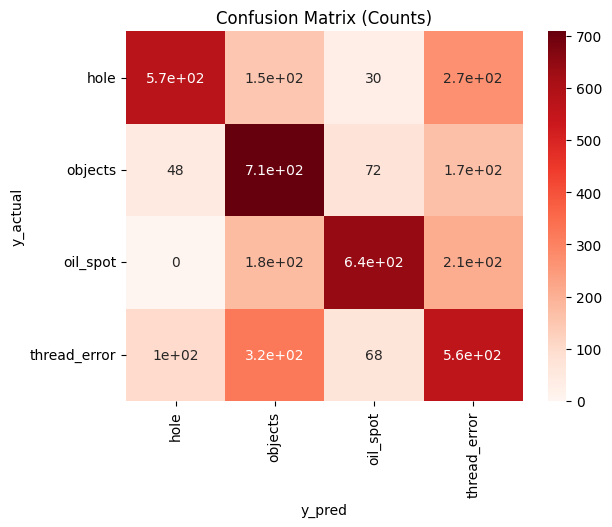


[[0.13922814 0.03663898 0.0073278  0.06595017]
 [0.01172447 0.172936   0.01758671 0.04103566]
 [0.         0.04298974 0.15632633 0.05080606]
 [0.02491451 0.07889595 0.01660967 0.1370298 ]]
sum of diagonal = 0.6055202735710796


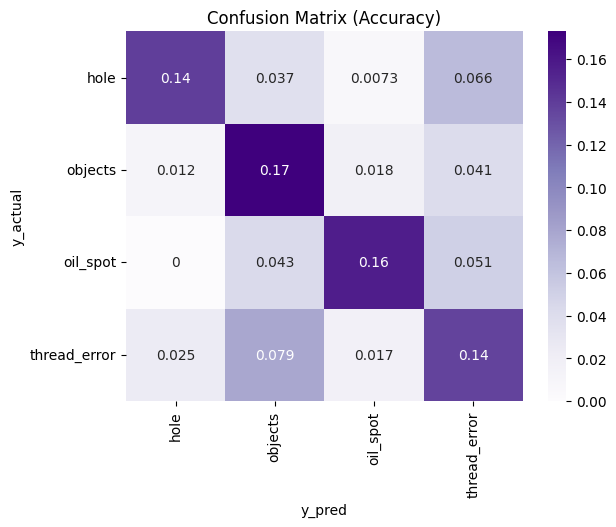


[[0.79166667 0.11053795 0.03703704 0.22369511]
 [0.06666667 0.52173913 0.08888889 0.13918807]
 [0.         0.12969786 0.79012346 0.17232809]
 [0.14166667 0.23802506 0.08395062 0.46478873]]
sum of diagonal = 2.5683179862859387


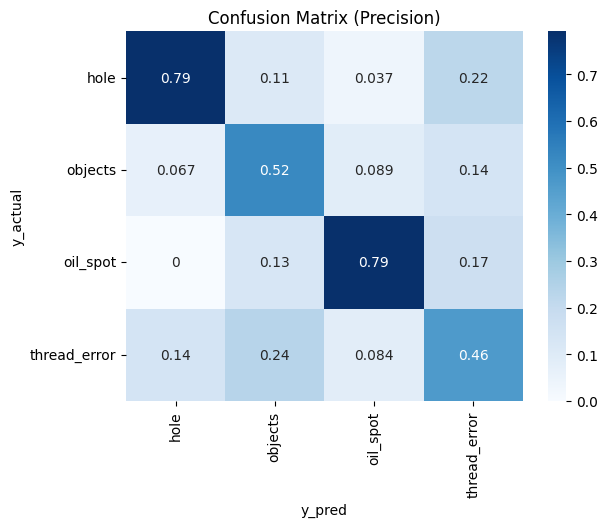


[[0.55882353 0.14705882 0.02941176 0.26470588]
 [0.04819277 0.71084337 0.07228916 0.1686747 ]
 [0.         0.171875   0.625      0.203125  ]
 [0.09677419 0.30645161 0.06451613 0.53225806]]
sum of diagonal = 2.4269249674218694


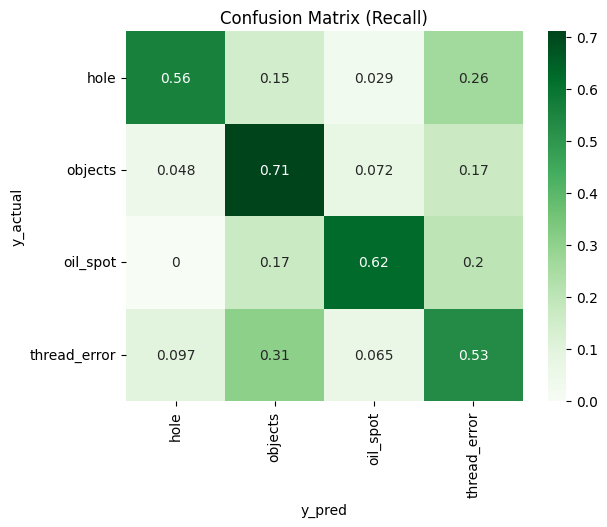

In [7]:
120
dim = [3]
nums_filters = 8
print('NEW MODEL')
print(f'filter dim = {dim}, number filter = {nums_filters}')
image_model = CNN_model(kernel_dims = dim, dropout=0.1,  nums_filters = nums_filters, patience = 100, lr = 0.0001, num_classes = 4)
history, image_learner = image_model.fit( features_train_defect_array, labels_defect_train, 
                                         features_eval_defect_array, labels_defect_eval, label_dict, batch_size = 256,
                                         verbose = 'auto', class_weight=class_weights)


with gzip.open(f"../data/models//defect_identification/DefID_image_learner_{str(dim)}_{str(nums_filters)}_d3blk.pckl", 'wb') as f:
    pickle.dump(image_learner, f)
with gzip.open(f"../data/models/defect_identification/DefID_history_{str(dim)}_{str(nums_filters)}_d3blk.pkl", 'wb') as f:
    pickle.dump(history, f)